### Validation schema

In [4]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
from sklearn.model_selection import train_test_split
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# models
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import catboost as cb

In [5]:
# # using ray engine for parallel calculation(for oprimization)
# %env MODIN_ENGINE=ray
# import modin.pandas as mpd

### Read data

In [6]:
# add data path to sys.path 
train_test_data_path = "C:\\Repository\\DS-Intership-data\\train_test_data\\"
sys.path.append(train_test_data_path)

# initiate dict for data
to_read_train_test_data = {}

# fill to_read
for dir_name, _, files in os.walk(train_test_data_path):
    for file in files:
        to_read_train_test_data[file] = dir_name + file

In [7]:
# check to_read
to_read_train_test_data

{'submission_example.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\submission_example.csv',
 'test_data.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\test_data.csv',
 'train_data.csv': 'C:\\Repository\\DS-Intership-data\\train_test_data\\train_data.csv'}

In [8]:
%%time
data = {}
# read data
for file, path in to_read_train_test_data.items():
    data[file.split('.')[0]] = pd.read_csv(os.path.join(os.path.dirname(path), file), index_col=0)

CPU times: total: 20.6 s
Wall time: 23.4 s


### Validation schema creation

In [9]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 n_splits=5,
                 model=DecisionTreeRegressor(max_depth=1, random_state=42),
                 check_nans = True,
                 dropna = False,
                 check_infs = True
                ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.tscv = TimeSeriesSplit(n_splits=self.n_splits)
    
        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
            
        # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        split_history = {
            'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
            'Train Data': [], 
            'Validation Data': []
        }
        for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
            split_history['Train Data'].append(train.max()-train.min())
            split_history['Validation Data'].append(val.max()-val.min())
        df = pd.DataFrame(split_history)
        print(df)
        sns.set(style="whitegrid")
        plt.figure(figsize=(6, 5))
        sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
        sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
        plt.title('Distribution of data for training and validation')
        plt.xlabel('Validation step')
        plt.ylabel('Data quantity')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()
    
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        
        # train model
        model = self.model
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    def evaluate(self, predictions_by_ID = True):
        
        eval_report = {}
        
        # Evaluation loop
        step = 0
        for train, val in self.tscv.split(self.y):
            
            # Initialize steps and timer
            step += 1
            ts = time.time()

            # Split data step
            y_tr, y_val = self.y.iloc[train], self.y.iloc[val]
            X_tr, X_val = self.X.iloc[train], self.X.iloc[val]

            # Train step
            rng = np.random.RandomState(42)
            model = self.model
            model.fit(X_tr, y_tr.item_cnt_month.values)

            # Evaluation step
            y_tr_pr = pd.DataFrame(index=X_tr.index, data=model.predict(X_tr.values), columns=['item_cnt_month'])
            y_val_pr = pd.DataFrame(index=X_val.index, data=model.predict(X_val.values), columns=['item_cnt_month'])
            
            # Extract step (predictions by ID)
            if predictions_by_ID:
                nan_report = {}
                y_tr = y_tr.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_train'] = f"{y_tr.item_cnt_month.isna().sum() / y_tr.shape[0] * 100} %"
                y_tr = y_tr.fillna(0).drop_duplicates(subset=['shop_id', 'item_id'])
                y_val = y_val.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_val'] = f"{y_val.item_cnt_month.isna().sum() / y_val.shape[0] * 100} %"
                y_val = y_val.fillna(0)
                y_tr_pr = X_tr.join(y_tr_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                            merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_train_pred'] = f"{y_tr_pr.item_cnt_month.isna().sum() / y_tr_pr.shape[0] * 100} %"
                y_tr_pr = y_tr_pr.fillna(0).drop_duplicates(subset=['shop_id', 'item_id'])
                y_val_pr = X_val.join(y_val_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                            merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                nan_report['y_val_pred'] = f"{y_val_pr.item_cnt_month.isna().sum() / y_val_pr.shape[0] * 100} %"
                y_val_pr = y_val_pr.fillna(0)
            
            # Calculate time required for step
            time_info = time.time() - ts
            
            # Metrics calucaltion step
            eval_report["step"+str(step)] = {
                "Train/Validation limits" : f"TRAIN: from {train.min()} to  {train.max()}  (size: {train.max() - train.min()} ) " +
                                      f"VALIDATION: from {val.min()} to  {val.max()}  (size: {val.max() - val.min()} )",
                "Train/Validation error" : [self.calculate_metrics(y_tr_pr.item_cnt_month, y_tr.item_cnt_month),
                           self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month)],
                "Nan_report" : nan_report,
                "Time for step" : f"{time_info} s",
                "__________________" : "_________________________________________________________________________________"
            }
            
        return eval_report     

Data is not sorted by time (18781 rows), it will be further sorted automatically
    Step  Train Data  Validation Data
0  Step1     1817153          1817153
1  Step2     3634307          1817153
2  Step3     5451461          1817153
3  Step4     7268615          1817153
4  Step5     9085769          1817153


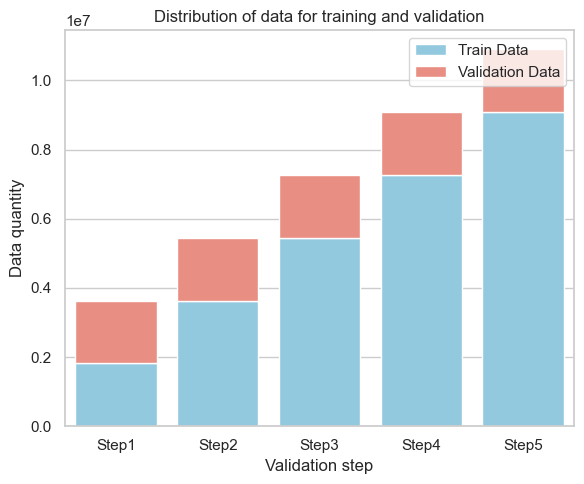

CPU times: total: 3.62 s
Wall time: 4.18 s


In [10]:
%%time
test_validation_class = Validation(
                 train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 n_splits=5,
                 model = DecisionTreeRegressor(max_depth=2, random_state=42),
                 check_nans=False
                )

In [11]:
%%time
test_validation_class.evaluate()

CPU times: total: 1min 29s
Wall time: 1min 43s


{'step1': {'Train/Validation limits': 'TRAIN: from 0 to  1817153  (size: 1817153 ) VALIDATION: from 1817154 to  3634307  (size: 1817153 )',
  'Train/Validation error': [3.949940635528056, 16.686743188026803],
  'Nan_report': {'y_train': '46.340786755725766 %',
   'y_val': '39.757940062677726 %',
   'y_train_pred': '46.340786755725766 %',
   'y_val_pred': '39.757940062677726 %'},
  'Time for step': '10.32190990447998 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation limits': 'TRAIN: from 0 to  3634307  (size: 3634307 ) VALIDATION: from 3634308 to  5451461  (size: 1817153 )',
  'Train/Validation error': [6.926649391667358, 7.623256580053565],
  'Nan_report': {'y_train': '26.396510219643844 %',
   'y_val': '29.74695447343304 %',
   'y_train_pred': '26.396510219643844 %',
   'y_val_pred': '29.74695447343304 %'},
  'Time for step': '10.984583139419556 s',
  '__________________': '___________________

In [12]:
%%time
test_validation_class.predict_target()

CPU times: total: 26.8 s
Wall time: 29.8 s


,ID,item_cnt_month
0,0,0.31
1,1,0.00
2,2,0.31
3,3,0.31
4,4,0.00
...,...,...
214195,214195,0.31
214196,214196,0.31
214197,214197,0.31
214198,214198,0.31


### Learn models

##### Linear Regression

Data is not sorted by time (5616 rows), it will be further sorted automatically
    Step  Train Data  Validation Data
0  Step1      364794           364792
1  Step2      729587           364792
2  Step3     1094380           364792
3  Step4     1459173           364792
4  Step5     1823966           364792


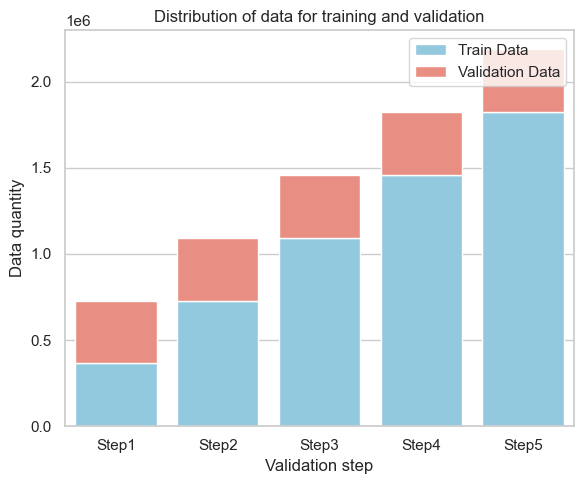

CPU times: total: 2.48 s
Wall time: 3.97 s


In [13]:
%%time
linear_regression = Validation(
                                 train_data=data['train_data'],
                                 test_data=data['test_data'],
                                 submission_example=data['submission_example'],
                                 n_splits=5,
                                 model = Ridge(alpha=0.1),
                                 check_nans=True,
                                 dropna = True
                           )

In [14]:
linear_regression_report = linear_regression.evaluate()

##### Random Forest Regressor

Data is not sorted by time (5616 rows), it will be further sorted automatically
    Step  Train Data  Validation Data
0  Step1      364794           364792
1  Step2      729587           364792
2  Step3     1094380           364792
3  Step4     1459173           364792
4  Step5     1823966           364792


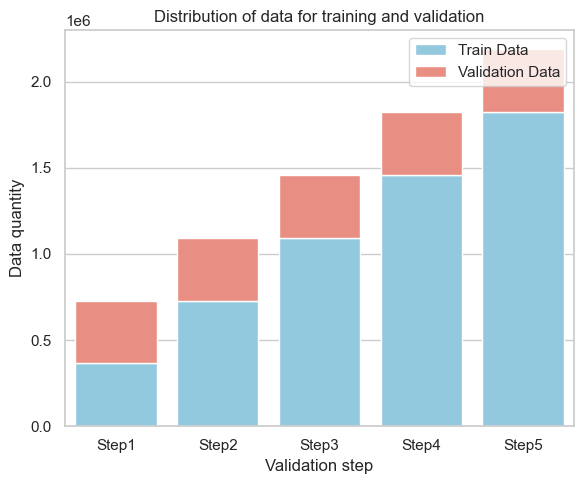

CPU times: total: 1.41 s
Wall time: 1.81 s


In [15]:
%%time
random_forest_regression = Validation(
                                 train_data=data['train_data'],
                                 test_data=data['test_data'],
                                 submission_example=data['submission_example'],
                                 n_splits=5,
                                 model = RandomForestRegressor(max_depth=4, n_estimators=25, random_state=42, n_jobs=-1),
                                 check_nans=True,
                                 dropna = True
                           )

In [16]:
%%time
random_forest_report = random_forest_regression.evaluate()
random_forest_report

CPU times: total: 12min 47s
Wall time: 1min 29s


{'step1': {'Train/Validation limits': 'TRAIN: from 0 to  364794  (size: 364794 ) VALIDATION: from 364795 to  729587  (size: 364792 )',
  'Train/Validation error': [0.38732321389351543, 11.78444362181632],
  'Nan_report': {'y_train': '44.90940654087392 %',
   'y_val': '37.53783357079595 %',
   'y_train_pred': '44.90940654087392 %',
   'y_val_pred': '37.53783357079595 %'},
  'Time for step': '4.06545352935791 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation limits': 'TRAIN: from 0 to  729587  (size: 729587 ) VALIDATION: from 729588 to  1094380  (size: 364792 )',
  'Train/Validation error': [0.7992210261625101, 2.649014122351398],
  'Nan_report': {'y_train': '24.961637094718665 %',
   'y_val': '31.311811905206195 %',
   'y_train_pred': '24.961637094718665 %',
   'y_val_pred': '31.311811905206195 %'},
  'Time for step': '9.620944023132324 s',
  '__________________': '______________________________

In [17]:
%%time
RandomForest_regression_submission = random_forest_regression.predict_target()

CPU times: total: 5min 57s
Wall time: 36.3 s


##### XGboost

Data is not sorted by time (18781 rows), it will be further sorted automatically
    Step  Train Data  Validation Data
0  Step1     1817153          1817153
1  Step2     3634307          1817153
2  Step3     5451461          1817153
3  Step4     7268615          1817153
4  Step5     9085769          1817153


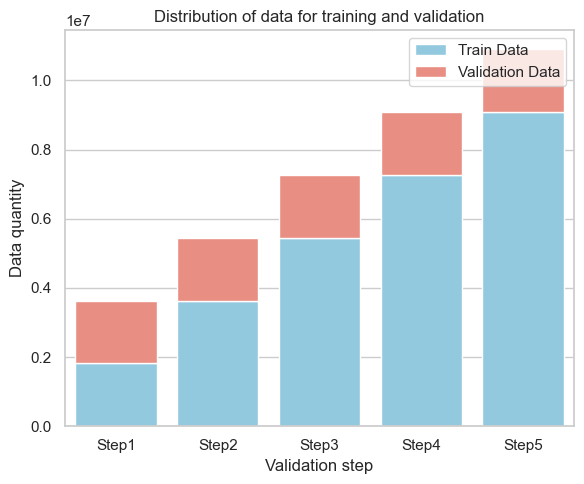

CPU times: total: 4.02 s
Wall time: 4.96 s


In [18]:
%%time
XGB_regression = Validation(
                     train_data=data['train_data'],
                     test_data=data['test_data'],
                     submission_example=data['submission_example'],
                     n_splits=5,
                     model = XGBRegressor(),
                     check_nans=False,
                     dropna = False
                 ) 

In [19]:
%%time
XGB_report = XGB_regression.evaluate()
XGB_report

CPU times: total: 19min 46s
Wall time: 2min 47s


{'step1': {'Train/Validation limits': 'TRAIN: from 0 to  1817153  (size: 1817153 ) VALIDATION: from 1817154 to  3634307  (size: 1817153 )',
  'Train/Validation error': [2.263853868984617, 8.099914762319932],
  'Nan_report': {'y_train': '46.340786755725766 %',
   'y_val': '39.757940062677726 %',
   'y_train_pred': '46.340786755725766 %',
   'y_val_pred': '39.757940062677726 %'},
  'Time for step': '13.156104803085327 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation limits': 'TRAIN: from 0 to  3634307  (size: 3634307 ) VALIDATION: from 3634308 to  5451461  (size: 1817153 )',
  'Train/Validation error': [4.17155317981123, 5.228557775228023],
  'Nan_report': {'y_train': '26.396510219643844 %',
   'y_val': '29.74695447343304 %',
   'y_train_pred': '26.396510219643844 %',
   'y_val_pred': '29.74695447343304 %'},
  'Time for step': '21.62836742401123 s',
  '__________________': '_____________________

In [20]:
%%time
XGB_regression_submission = XGB_regression.predict_target()

CPU times: total: 7min 24s
Wall time: 53.4 s


##### LightGBM

Data is not sorted by time (18781 rows), it will be further sorted automatically
    Step  Train Data  Validation Data
0  Step1     1817153          1817153
1  Step2     3634307          1817153
2  Step3     5451461          1817153
3  Step4     7268615          1817153
4  Step5     9085769          1817153


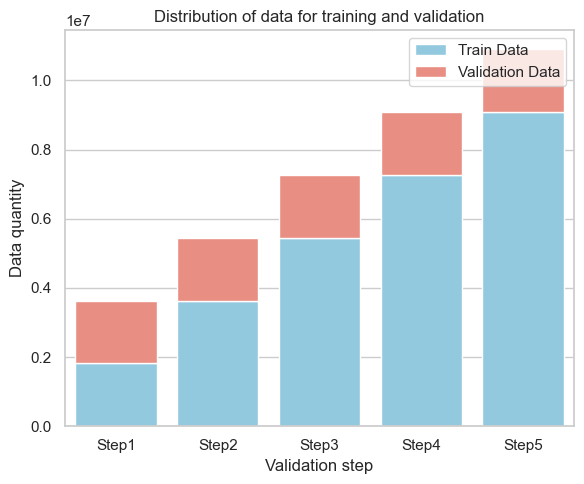

CPU times: total: 6.64 s
Wall time: 16 s


In [21]:
%%time

LightGBM_regression = Validation(
                     train_data=data['train_data'],
                     test_data=data['test_data'],
                     submission_example=data['submission_example'],
                     n_splits=5,
                     model = lgb.LGBMRegressor(),
                     check_nans=False,
                     dropna = False
                 ) 

In [22]:
%%time
LightGBM_report = LightGBM_regression.evaluate()
LightGBM_report

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2733
[LightGBM] [Info] Number of data points in the train set: 1817154, number of used features: 30
[LightGBM] [Info] Start training from score 0.330936
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 3634308, number of used features: 30
[LightGBM] [Info] Start training from score 0.329261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.291931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

{'step1': {'Train/Validation limits': 'TRAIN: from 0 to  1817153  (size: 1817153 ) VALIDATION: from 1817154 to  3634307  (size: 1817153 )',
  'Train/Validation error': [2.070722263042826, 8.63634500188383],
  'Nan_report': {'y_train': '46.340786755725766 %',
   'y_val': '39.757940062677726 %',
   'y_train_pred': '46.340786755725766 %',
   'y_val_pred': '39.757940062677726 %'},
  'Time for step': '15.079569578170776 s',
  '__________________': '_________________________________________________________________________________'},
 'step2': {'Train/Validation limits': 'TRAIN: from 0 to  3634307  (size: 3634307 ) VALIDATION: from 3634308 to  5451461  (size: 1817153 )',
  'Train/Validation error': [4.3285185326141535, 5.000410818776253],
  'Nan_report': {'y_train': '26.396510219643844 %',
   'y_val': '29.74695447343304 %',
   'y_train_pred': '26.396510219643844 %',
   'y_val_pred': '29.74695447343304 %'},
  'Time for step': '19.159780502319336 s',
  '__________________': '___________________

In [23]:
%%time
LightGBM_regression_submission = LightGBM_regression.predict_target()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.572630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3677
[LightGBM] [Info] Number of data points in the train set: 10902924, number of used features: 32
[LightGBM] [Info] Start training from score 0.322979
CPU times: total: 2min 13s
Wall time: 36.1 s


##### Catboost

Data is not sorted by time (18781 rows), it will be further sorted automatically
    Step  Train Data  Validation Data
0  Step1     1817153          1817153
1  Step2     3634307          1817153
2  Step3     5451461          1817153
3  Step4     7268615          1817153
4  Step5     9085769          1817153


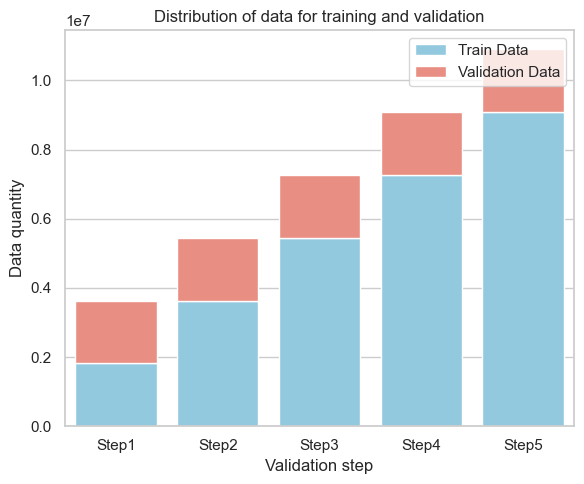

CPU times: total: 4.38 s
Wall time: 7 s


In [24]:
%%time
catboost_regression = Validation(
                 train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 n_splits=5,
                 model = cb.CatBoostRegressor(),
                 check_nans=False,
                 dropna = False
                )

In [61]:
CatBoost_report = catboost_regression.evaluate()
CatBoost_report

In [62]:
%%time
CatBoost_regression_submission = catboost_regression.predict_target()

### Сomparison of models based on validation results

In [51]:
scores = pd.MultiIndex.from_product([["step " + str(i) for i in range(1, 6)],
                                  ['train_score', 'validation_score']],
                                 names=['Steps', 'Score'])
models = ['RandomForest', 'XGB', 'LightGBM', 'CatBoost']
df = pd.DataFrame('-', scores, models)

steps =  ["step" + str(i) for i in range(1, 6)]
reports = {'RandomForest': random_forest_report,
           'XGB':XGB_report,
           'LightGBM':LightGBM_report,
           'CatBoost':CatBoost_report
          }
for model, report in reports.items():
    temp = []
    for step in steps:
        temp.append(report[step]['Train/Validation error'][0])
        temp.append(report[step]['Train/Validation error'][1])
    df[model] = temp
df

RandomForest   XGB  LightGBM  CatBoost
Steps  Score                                                   
step 1 train_score               0.39  2.26      2.07      2.17
       validation_score         11.78  8.10      8.64      6.87
step 2 train_score               0.80  4.17      4.33      4.03
       validation_score          2.65  5.23      5.00      4.67
step 3 train_score               0.94  6.67      6.62      5.85
       validation_score          3.94  3.61      3.27      3.35
step 4 train_score               1.09  7.74      8.59      7.48
       validation_score          6.44  4.71      4.09      4.35
step 5 train_score               1.29 11.17     11.43     10.34
       validation_score          1.26  2.68      2.49      2.57

### Save submission results

In [58]:
submission_data = {
    'RF_submission' : RandomForest_regression_submission,
    'XGB_submission' : XGB_regression_submission,
    'LightGBM_submission' : LightGBM_regression_submission,
    'CatBoost_submission' : CatBoost_regression_submission
}

In [59]:
%%time
# add path to load to sys.path 
path_to_load = "C:\\Repository\\DS-Intership-data\\baseline_submissions\\"
os.makedirs(path_to_load, exist_ok=True)
sys.path.append(path_to_load)

# load data 
for file, df in submission_data.items():
    df.to_csv(path_to_load+file+".csv", index=False)

CPU times: total: 969 ms
Wall time: 1.12 s


In [60]:
from os import listdir
from os.path import isfile, join
print(*[f+"\n" for f in listdir(path_to_load) if isfile(join(path_to_load, f))])

CatBoost_submission.csv
 LightGBM_submission.csv
 RF_submission.csv
 XGB_submission.csv



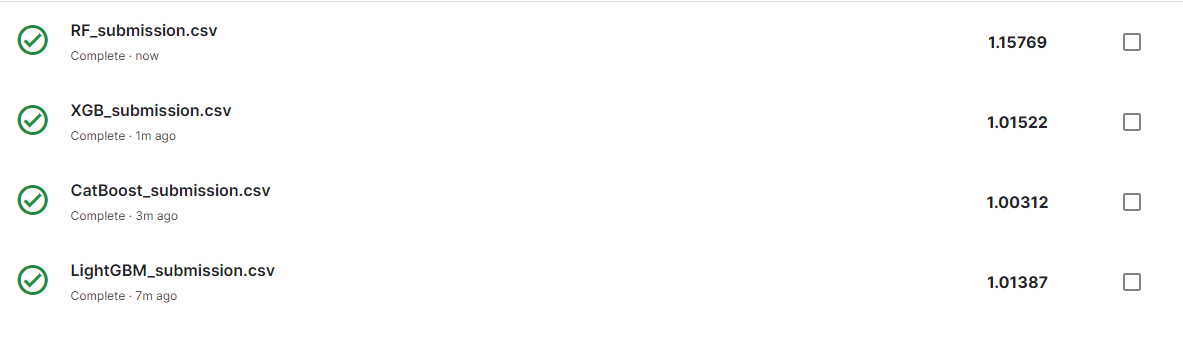